## First: New Structured Relational Data Model

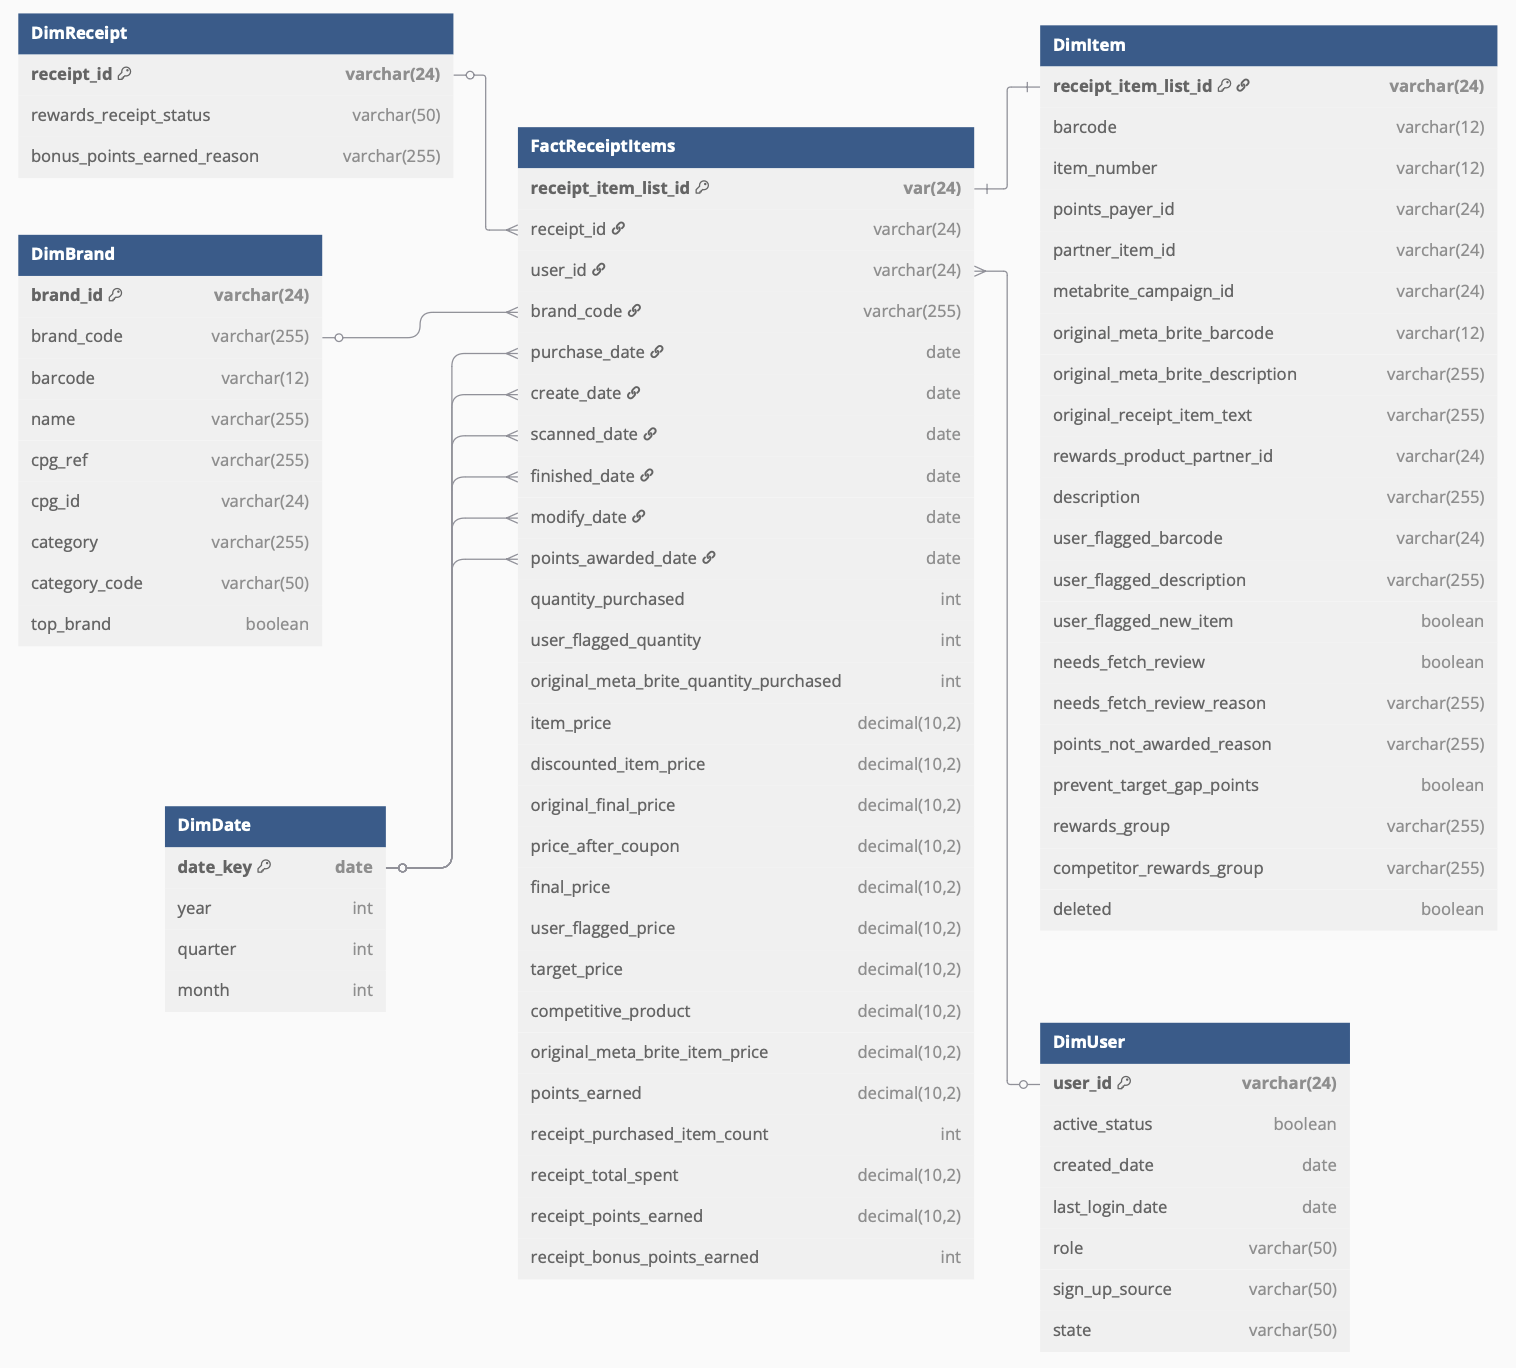

In [1]:
import pandas as pd
from datetime import timezone
import numpy as np
import json
import sqlite3
from sqlite3 import Error
import hashlib

## Data Transformation for Star Schema

In [2]:
users_df = pd.read_json('users.json', lines=True)

users_df['_id'] = users_df['_id'].apply(lambda x: x.get('$oid') if isinstance(x, dict) else x)

date_cols = ['createdDate', 'lastLogin']

for col in date_cols:
    users_df[col] = pd.to_datetime(users_df[col].apply(lambda x: x.get('$date') if isinstance(x, dict) else x), unit='ms', errors='coerce', utc=True).dt.date

DimUser_df = users_df.rename(columns={
    '_id': 'user_id',
    'active': 'active_status',
    'createdDate': 'created_date',
    'lastLogin': 'last_login_date',
    'signUpSource': 'sign_up_source',
})

DimUser_df = DimUser_df.drop_duplicates()

print("DimUser_df:")
print(DimUser_df.info())

DimUser_df:
<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 475
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          212 non-null    object
 1   active_status    212 non-null    bool  
 2   created_date     212 non-null    object
 3   last_login_date  172 non-null    object
 4   role             212 non-null    object
 5   sign_up_source   207 non-null    object
 6   state            206 non-null    object
dtypes: bool(1), object(6)
memory usage: 11.8+ KB
None


In [3]:
brands_df = pd.read_json('brands.json', lines=True)

brands_df['_id'] = brands_df['_id'].apply(lambda x: x.get('$oid') if isinstance(x, dict) else x)

# Flattern cpg json to id and ref column 
brands_df['cpg_id'] = brands_df['cpg'].apply(lambda x: x.get('$id', {}).get('$oid', None) if isinstance(x, dict) else None)
brands_df['cpg_ref'] = brands_df['cpg'].apply(lambda x: x.get('$ref', None) if isinstance(x, dict) else None)

brands_df.drop(columns=['cpg'], inplace=True)

DimBrand_df = brands_df.rename(columns={
    '_id': 'brand_id',
    'barcode': 'barcode',
    'brandCode': 'brand_code',
    'categoryCode': 'category_code',
    'topBrand': 'top_brand'
})

DimBrand_df = DimBrand_df[[
    'brand_id', 'barcode', 'brand_code', 'name', 'cpg_ref', 'cpg_id', 'category', 'category_code', 'top_brand'
]]

DimBrand_df['top_brand'] = DimBrand_df['top_brand'].astype(bool)

DimBrand_df = DimBrand_df.drop_duplicates()

print("DimBrand_df:")
print(DimBrand_df.head())

DimBrand_df:
                   brand_id       barcode                     brand_code  \
0  601ac115be37ce2ead437551  511111019862                            NaN   
1  601c5460be37ce2ead43755f  511111519928                      STARBUCKS   
2  601ac142be37ce2ead43755d  511111819905  TEST BRANDCODE @1612366146176   
3  601ac142be37ce2ead43755a  511111519874  TEST BRANDCODE @1612366146051   
4  601ac142be37ce2ead43755e  511111319917  TEST BRANDCODE @1612366146827   

                        name cpg_ref                    cpg_id  \
0  test brand @1612366101024    Cogs  601ac114be37ce2ead437550   
1                  Starbucks    Cogs  5332f5fbe4b03c9a25efd0ba   
2  test brand @1612366146176    Cogs  601ac142be37ce2ead437559   
3  test brand @1612366146051    Cogs  601ac142be37ce2ead437559   
4  test brand @1612366146827    Cogs  5332fa12e4b03c9a25efd1e7   

         category     category_code  top_brand  
0          Baking            BAKING      False  
1       Beverages         BEVERAGES

In [4]:
receipts_raw_df = pd.read_json('receipts.json', lines=True)

receipts_raw_df['_id'] = receipts_raw_df['_id'].apply(lambda x: x.get('$oid') if isinstance(x, dict) else x)
receipts_raw_df = receipts_raw_df.rename(columns={'pointsEarned': 'receipt_points_earned'})
    
# Explode the rewardsReceiptItemList
receipts_df = receipts_raw_df.explode('rewardsReceiptItemList').reset_index(drop=True)

# Create receipt_item_list_id
receipts_df['temp_index'] = range(len(receipts_df))  # Temporary index
receipts_df['receipt_item_list_id'] = ''

# 1. Handle cases WITH items
valid_items_mask = receipts_df['rewardsReceiptItemList'].notna()
# Create a longer, more unique base ID (before hashing)
long_id = receipts_df.loc[valid_items_mask, '_id'] + '_' + receipts_df.loc[valid_items_mask, 'temp_index'].astype(str)
# Use SHA-256 hashing and take the first 24 characters
receipts_df.loc[valid_items_mask, 'receipt_item_list_id'] = long_id.apply(lambda x: hashlib.sha256(x.encode()).hexdigest()[:24])

# 2. Handle cases WITHOUT items (with "noreceipt" prefix)
no_items_mask = receipts_df['rewardsReceiptItemList'].isna()
# Build the long ID with the prefix *before* hashing
long_id_no_receipt = 'noreceipt_' + receipts_df.loc[no_items_mask, '_id'] + '_' + receipts_df.loc[no_items_mask, 'temp_index'].astype(str)

# Hash and truncate, but make sure "noreceipt" is preserved
def hash_with_prefix(long_id):
    hashed = hashlib.sha256(long_id.encode()).hexdigest()
    # Ensure the final ID starts with "noreceipt" and is 24 chars long
    if long_id.startswith('noreceipt_'):
        return 'noreceipt' + hashed[:14]  # Take 14 chars from hash
    else:
         return hashed[:24]

receipts_df.loc[no_items_mask, 'receipt_item_list_id'] = long_id_no_receipt.apply(hash_with_prefix)

# Normalize rewardsReceiptItemList
rewards_receipt_item_list = receipts_df['rewardsReceiptItemList'].apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series({}))
receipts_df = pd.concat([receipts_df.drop(['rewardsReceiptItemList', 'temp_index'], axis=1), rewards_receipt_item_list], axis=1)

# Convert date columns to datetime objects (after setting 'object' type)
date_cols = ['purchaseDate', 'createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate']

for col in date_cols:
    receipts_df[col] = pd.to_datetime(receipts_df[col].apply(lambda x: x.get('$date') if isinstance(x, dict) else x), unit='ms', errors='coerce', utc=True).dt.date

# --- Create DimItem ---
DimItem_df = receipts_df[[
    'receipt_item_list_id', 'barcode', 'itemNumber', 'pointsPayerId', 'partnerItemId', 'metabriteCampaignId',
    'originalMetaBriteBarcode', 'originalMetaBriteDescription', 'originalReceiptItemText',
    'rewardsProductPartnerId', 'description', 'userFlaggedBarcode', 'userFlaggedDescription',
    'userFlaggedNewItem', 'needsFetchReview', 'needsFetchReviewReason', 'pointsNotAwardedReason',
    'preventTargetGapPoints', 'rewardsGroup', 'competitorRewardsGroup', 'deleted'
]].copy()
DimItem_df = DimItem_df.drop_duplicates(subset=['receipt_item_list_id']).dropna(subset=['receipt_item_list_id'])
DimItem_df.columns = [
    'receipt_item_list_id', 'barcode', 'item_number', 'points_payer_id', 'partner_item_id', 'metabrite_campaign_id',
    'original_meta_brite_barcode', 'original_meta_brite_description', 'original_receipt_item_text',
    'rewards_product_partner_id', 'description', 'user_flagged_barcode', 'user_flagged_description',
    'user_flagged_new_item', 'needs_fetch_review', 'needs_fetch_review_reason', 'points_not_awarded_reason',
    'prevent_target_gap_points', 'rewards_group', 'competitor_rewards_group', 'deleted'
]

bool_cols = ['user_flagged_new_item', 'needs_fetch_review', 'prevent_target_gap_points', 'deleted']

for col in bool_cols:
    DimItem_df[col] = DimItem_df[col].fillna(False)
    DimItem_df[col] = DimItem_df[col].astype(bool)

# --- Create DimReceipt ---
DimReceipt_df = receipts_df[['_id', 'rewardsReceiptStatus', 'bonusPointsEarnedReason']].copy()
DimReceipt_df = DimReceipt_df.drop_duplicates(subset=['_id'])
DimReceipt_df.columns = ['receipt_id', 'rewards_receipt_status', 'bonus_points_earned_reason']

# --- Create FactReceiptItems ---
FactReceiptItems_df = receipts_df[[
    'receipt_item_list_id', '_id', 'userId', 
    'brandCode', 'purchaseDate', 'createDate', 'dateScanned', 'finishedDate', 'modifyDate',
    'pointsAwardedDate', 'quantityPurchased', 'userFlaggedQuantity',
    'originalMetaBriteQuantityPurchased', 'itemPrice', 'discountedItemPrice',
    'originalFinalPrice', 'priceAfterCoupon', 'finalPrice', 'userFlaggedPrice',
    'targetPrice', 'competitiveProduct', 'originalMetaBriteItemPrice',
    'pointsEarned', 'purchasedItemCount', 'totalSpent', 'bonusPointsEarned', 'receipt_points_earned'
]].copy()

# Rename columns
FactReceiptItems_df = FactReceiptItems_df.rename(columns={
    '_id': 'receipt_id',
    'userId': 'user_id',
    'brandCode': 'brand_code',
    'purchaseDate': 'purchase_date',
    'createDate': 'create_date',
    'dateScanned': 'scanned_date',
    'finishedDate': 'finished_date',
    'modifyDate': 'modify_date',
    'pointsAwardedDate': 'points_awarded_date',
    'quantityPurchased': 'quantity_purchased',
    'userFlaggedQuantity': 'user_flagged_quantity',
    'originalMetaBriteQuantityPurchased': 'original_meta_brite_quantity_purchased',
    'itemPrice': 'item_price',
    'discountedItemPrice': 'discounted_item_price',
    'originalFinalPrice': 'original_final_price',
    'priceAfterCoupon': 'price_after_coupon',
    'finalPrice': 'final_price',
    'userFlaggedPrice': 'user_flagged_price',
    'targetPrice': 'target_price',
    'competitiveProduct': 'competitive_product',
    'originalMetaBriteItemPrice': 'original_meta_brite_item_price',
    'pointsEarned': 'points_earned',
    'purchasedItemCount': 'receipt_purchased_item_count',
    'totalSpent': 'receipt_total_spent',
    'bonusPointsEarned': 'receipt_bonus_points_earned'
})

# Ensure correct column order
FactReceiptItems_df = FactReceiptItems_df[[
    'receipt_item_list_id', 'receipt_id', 'user_id', 'brand_code',
    'purchase_date', 'create_date', 'scanned_date', 'finished_date',
    'modify_date', 'points_awarded_date', 'quantity_purchased',
    'user_flagged_quantity', 'original_meta_brite_quantity_purchased',
    'item_price', 'discounted_item_price', 'original_final_price',
    'price_after_coupon', 'final_price', 'user_flagged_price',
    'target_price', 'competitive_product', 'original_meta_brite_item_price',
    'points_earned', 'receipt_purchased_item_count', 'receipt_total_spent',
    'receipt_bonus_points_earned', 'receipt_points_earned'
]]

# Drop rows where receipt_item_list_id is null *BEFORE* type conversion
FactReceiptItems_df = FactReceiptItems_df.dropna(subset=['receipt_item_list_id'])

# Convert data types *after* dropping NA rows
type_mapping = {
    'object': ['receipt_item_list_id', 'receipt_id', 'user_id', 'brand_code'],
    'Int64': ['quantity_purchased', 'user_flagged_quantity', 'original_meta_brite_quantity_purchased',
              'receipt_purchased_item_count', 'receipt_bonus_points_earned'],
    'float64': ['item_price', 'discounted_item_price', 'original_final_price', 'price_after_coupon',
                'final_price', 'user_flagged_price', 'target_price', 'competitive_product',
                'original_meta_brite_item_price', 'points_earned', 'receipt_total_spent',
                'receipt_points_earned']
}

for dtype, cols in type_mapping.items():
    for col in cols:
        FactReceiptItems_df[col] = FactReceiptItems_df[col].astype(dtype)
        
print("DimItem_df:")
print(DimItem_df.info())
print("DimReceipt_df:")
print(DimReceipt_df.info())
print("FactReceiptItems_df:")
print(FactReceiptItems_df.info())

DimItem_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   receipt_item_list_id             7381 non-null   object
 1   barcode                          3090 non-null   object
 2   item_number                      153 non-null    object
 3   points_payer_id                  1267 non-null   object
 4   partner_item_id                  6941 non-null   object
 5   metabrite_campaign_id            863 non-null    object
 6   original_meta_brite_barcode      71 non-null     object
 7   original_meta_brite_description  10 non-null     object
 8   original_receipt_item_text       5760 non-null   object
 9   rewards_product_partner_id       2269 non-null   object
 10  description                      6560 non-null   object
 11  user_flagged_barcode             337 non-null    object
 12  user_flagged_descripti

/var/folders/sw/mn9s3_ws4t9_4jcz4rhtt2vw0000gn/T/ipykernel_846/2577104029.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DimItem_df[col] = DimItem_df[col].fillna(False)
/var/folders/sw/mn9s3_ws4t9_4jcz4rhtt2vw0000gn/T/ipykernel_846/2577104029.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DimItem_df[col] = DimItem_df[col].fillna(False)
/var/folders/sw/mn9s3_ws4t9_4jcz4rhtt2vw0000gn/T/ipykernel_846/2577104029.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call

In [5]:
date_cols = ['scanned_date']

for col in date_cols:
    FactReceiptItems_df[col] = pd.to_datetime(FactReceiptItems_df[col], errors='coerce')

# --- Date Analysis ---
for col in date_cols:
    print(f"--- {col} ---")
    print(f"  Min: {FactReceiptItems_df[col].min()}")
    print(f"  Max: {FactReceiptItems_df[col].max()}")
    print(f"  Number of NaT: {FactReceiptItems_df[col].isna().sum()}") # Count NaT values
    print()

date_cols = ['created_date', 'last_login_date']

for col in date_cols:
    DimUser_df[col] = pd.to_datetime(DimUser_df[col], errors='coerce')
    
# --- Date Analysis ---
for col in date_cols:
    print(f"--- {col} ---")
    print(f"  Min: {DimUser_df[col].min()}")
    print(f"  Max: {DimUser_df[col].max()}")
    print(f"  Number of NaT: {DimUser_df[col].isna().sum()}") # Count NaT values
    print()

--- scanned_date ---
  Min: 2020-10-30 00:00:00
  Max: 2021-03-01 00:00:00
  Number of NaT: 0

--- created_date ---
  Min: 2014-12-19 00:00:00
  Max: 2021-02-12 00:00:00
  Number of NaT: 0

--- last_login_date ---
  Min: 2018-05-07 00:00:00
  Max: 2021-03-05 00:00:00
  Number of NaT: 40



In [6]:
# Create a date range.  Adjust start and end as needed.
start_date = '2017-01-01'
end_date = '2021-12-31'  # Or a future date

# Create the date range
dates = pd.date_range(start=start_date, end=end_date)

# Create the DimDate DataFrame
DimDate_df = pd.DataFrame({'date_key': dates})

# Extract year, quarter, and month
DimDate_df['year'] = DimDate_df['date_key'].dt.year
DimDate_df['quarter'] = DimDate_df['date_key'].dt.quarter
DimDate_df['month'] = DimDate_df['date_key'].dt.month

print("DimDate_df:")
print(DimDate_df.info())

DimDate_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date_key  1826 non-null   datetime64[ns]
 1   year      1826 non-null   int32         
 2   quarter   1826 non-null   int32         
 3   month     1826 non-null   int32         
dtypes: datetime64[ns](1), int32(3)
memory usage: 35.8 KB
None


## Database Initialization: Table Creation and Data Loading

In [7]:
def connect_database(db_file):
    try:
        conn = sqlite3.connect(db_file)
        conn.row_factory = sqlite3.Row  # 
        return conn
    except Error as e:
        print(f"Database connection error: {e}")
        return None

def create_table(conn, create_table_sql):
    try:
        with conn:  
            conn.execute(create_table_sql)
    except Error as e:
        print(f"Table creation error: {e}")

def insert_records(conn, insert_sql, data_df):
    try:
        data_to_insert = [tuple(row) for row in data_df.itertuples(index=False)]

        with conn:  
            conn.executemany(insert_sql, data_to_insert)
            print("Data inserted successfully!")

    except Error as e:
        print(f"Data insertion error: {e}")

def select_query_df(conn, select_sql):
    try:
        with conn:
            df = pd.read_sql_query(select_sql, conn)
            pd.set_option('display.max_columns', None)
            print(df)
            return 
    except Error as e:
        print(f"Query execution error: {e}")
        return pd.DataFrame()  

In [8]:
conn = connect_database(':memory:')

In [9]:
create_DimUser_table_sql = '''
CREATE TABLE DimUser(
user_id varchar(24) PRIMARY KEY,
active_status boolean,
created_date date,
last_login_date date,
role varchar(50),
sign_up_source varchar(50),
state varchar(50)
);
'''

create_DimBrand_table_sql = '''
CREATE TABLE DimBrand(
brand_id varchar(24) PRIMARY KEY,
barcode varchar(12),
brand_code varchar(255),
name varchar(255),
cpg_ref varchar(255),
cpg_id varchar(24),
category varchar(255),
category_code varchar(50),
top_brand boolean
);
'''

create_DimDate_table_sql = '''
CREATE TABLE DimDate(
date_key date PRIMARY KEY,
year integer,
quarter integer,
month integer
);
'''

create_DimReceipt_table_sql = '''
CREATE TABLE DimReceipt(
receipt_id varchar(24) PRIMARY KEY,
rewards_receipt_status varchar(50),
bonus_points_earned_reason varchar(255)
);
'''

create_DimItem_table_sql = '''
CREATE TABLE DimItem(
receipt_item_list_id varchar(24) PRIMARY KEY,
barcode varchar(12),
item_number varchar(12),
points_payer_id varchar(24),
partner_item_id varchar(24),
metabrite_campaign_id varchar(24),
original_meta_brite_barcode varchar(12),
original_meta_brite_description varchar(255),
original_receipt_item_text varchar(255),
rewards_product_partner_id varchar(24),
description varchar(255),
user_flagged_barcode varchar(24),
user_flagged_description varchar(255),
user_flagged_new_item boolean,
needs_fetch_review boolean,
needs_fetch_review_reason varchar(255),
points_not_awarded_reason varchar(255),
prevent_target_gap_points boolean,
rewards_group varchar(255),
competitor_rewards_group varchar(255),
deleted boolean
);
'''

create_FactReceiptItems_table_sql = '''
CREATE TABLE FactReceiptItems(
receipt_item_list_id varchar(24) PRIMARY KEY,
receipt_id varchar(24),
user_id varchar(24),
brand_code varchar(255),
purchase_date date,
create_date date,
scanned_date date,
finished_date date,
modify_date date,
points_awarded_date date,
quantity_purchased integer,
user_flagged_quantity integer,
original_meta_brite_quantity_purchased integer,
item_price decimal(10, 2),
discounted_item_price decimal(10, 2),
original_final_price decimal(10, 2),
price_after_coupon decimal(10, 2),
final_price decimal(10, 2),
user_flagged_price decimal(10, 2),
target_price decimal(10, 2),
competitive_product decimal(10, 2),
original_meta_brite_item_price decimal(10, 2),
points_earned decimal(10, 2),
receipt_purchased_item_count integer,
receipt_total_spent decimal(10, 2),
receipt_points_earned decimal(10, 2),
receipt_bonus_points_earned integer
);
'''

In [10]:
if conn:
    create_table(conn, create_DimUser_table_sql)
    create_table(conn, create_DimBrand_table_sql)
    create_table(conn, create_DimDate_table_sql)
    create_table(conn, create_DimReceipt_table_sql)
    create_table(conn, create_DimItem_table_sql)
    create_table(conn, create_FactReceiptItems_table_sql)
else:
    print('Error in connecting to the database!')

In [11]:
if conn:
    insert_DimUser = "INSERT INTO DimUser (user_id, active_status, created_date, last_login_date, role, sign_up_source, state) VALUES (?, ?, ?, ?, ?, ?, ?)"
    DimUser_df['created_date'] = pd.to_datetime(DimUser_df['created_date']).dt.strftime('%Y-%m-%d')
    DimUser_df['last_login_date'] = pd.to_datetime(DimUser_df['last_login_date']).dt.strftime('%Y-%m-%d')    
    insert_records(conn, insert_DimUser, DimUser_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


In [12]:
if conn:
    insert_DimBrand = "INSERT INTO DimBrand (brand_id, barcode, brand_code, name, cpg_ref, cpg_id, category, category_code, top_brand) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)"
    insert_records(conn, insert_DimBrand, DimBrand_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


In [13]:
if conn:
    insert_DimDate = "INSERT INTO DimDate (date_key, year, quarter, month) VALUES (?, ?, ?, ?)"
    DimDate_df['date_key'] = pd.to_datetime(DimDate_df['date_key']).dt.strftime('%Y-%m-%d')
    insert_records(conn, insert_DimDate, DimDate_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


In [14]:
if conn:
    insert_DimReceipt = "INSERT INTO DimReceipt (receipt_id, rewards_receipt_status, bonus_points_earned_reason) VALUES (?, ?, ?)"
    insert_records(conn, insert_DimReceipt, DimReceipt_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


In [15]:
if conn:
    insert_DimItem = "INSERT INTO DimItem (receipt_item_list_id, barcode, item_number, points_payer_id, partner_item_id, metabrite_campaign_id, original_meta_brite_barcode, original_meta_brite_description, original_receipt_item_text, rewards_product_partner_id, description, user_flagged_barcode, user_flagged_description, user_flagged_new_item, needs_fetch_review, needs_fetch_review_reason, points_not_awarded_reason, prevent_target_gap_points, rewards_group, competitor_rewards_group, deleted) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    insert_records(conn, insert_DimItem, DimItem_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


In [16]:
if conn:
    insert_FactReceiptItems = "INSERT INTO FactReceiptItems (receipt_item_list_id, receipt_id, user_id, brand_code, purchase_date, create_date, scanned_date, finished_date, modify_date, points_awarded_date, quantity_purchased, user_flagged_quantity, original_meta_brite_quantity_purchased, item_price, discounted_item_price, original_final_price, price_after_coupon, final_price, user_flagged_price, target_price, competitive_product, original_meta_brite_item_price, points_earned, receipt_purchased_item_count, receipt_total_spent, receipt_bonus_points_earned, receipt_points_earned) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    
    date_cols = ['purchase_date', 'create_date', 'scanned_date', 'finished_date', 'modify_date', 'points_awarded_date']
    for col in date_cols:
        FactReceiptItems_df[col] = pd.to_datetime(FactReceiptItems_df[col], errors='coerce').dt.strftime('%Y-%m-%d')
        
    for col in FactReceiptItems_df.select_dtypes(include=['Int64']):
        FactReceiptItems_df[col] = FactReceiptItems_df[col].fillna(0)
        FactReceiptItems_df[col] = FactReceiptItems_df[col].astype(np.int64)
        
    insert_records(conn, insert_FactReceiptItems, FactReceiptItems_df)

else:
    print('Cannot Insert Records. Error in connecting to the database!')

Data inserted successfully!


## Second: SQL queries answer predetermined questions

In [17]:
#1 What are the top 5 brands by receipts scanned for most recent month?
#2 How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month? 

top_5_brands_recent_two_months_sql = '''
WITH RecentDate AS (
    SELECT 
        STRFTIME('%Y', MAX(scanned_date)) AS recent_year
        , STRFTIME('%m', MAX(scanned_date)) AS recent_month
        , STRFTIME('%Y', DATE(MAX(scanned_date), '-1 month')) AS previous_year
        , STRFTIME('%m', DATE(MAX(scanned_date), '-1 month')) AS previous_month
    FROM FactReceiptItems 
),
RankedBrandsRecent AS (
    SELECT 
        db.name AS brand_name
        , COUNT(DISTINCT fr.receipt_id) AS receipt_cnt
        , ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT fr.receipt_id) DESC) AS rk_recent
    FROM FactReceiptItems fr
       LEFT JOIN DimBrand db
           ON fr.brand_code = db.brand_code 
       LEFT JOIN DimDate dd
           ON fr.scanned_date = dd.date_key
       INNER JOIN RecentDate md
           ON dd.year = md.recent_year AND dd.month = md.recent_month
    WHERE 
        fr.brand_code IS NOT NULL
        AND db.name IS NOT NULL        
    GROUP BY 
        db.name
),
RankedBrandsPrevious AS (
    SELECT 
        db.name AS brand_name
        , COUNT(DISTINCT fr.receipt_id) AS receipt_cnt
        , ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT fr.receipt_id) DESC) AS rk_previous
    FROM FactReceiptItems fr
       LEFT JOIN DimBrand db
            ON fr.brand_code = db.brand_code 
       LEFT JOIN DimDate dd
            ON fr.scanned_date = dd.date_key
       INNER JOIN RecentDate md
           ON dd.year = md.previous_year AND dd.month = md.previous_month
    WHERE 
        fr.brand_code IS NOT NULL
        AND db.name IS NOT NULL
    GROUP BY 
        db.name
)

SELECT
    COALESCE(rbr.brand_name, rbp.brand_name) AS brand_name
    , rbr.rk_recent
    , rbp.rk_previous
    , rbr.receipt_cnt AS recent_receipt_cnt
    , rbp.receipt_cnt AS previous_receipt_cnt
FROM RankedBrandsRecent rbr
    FULL OUTER JOIN RankedBrandsPrevious rbp 
        ON rbr.brand_name = rbp.brand_name
WHERE 
    rbr.rk_recent <= 5 
    OR rbp.rk_previous <=5
ORDER BY 
    rbr.rk_recent
    , rbp.rk_previous
;'''

select_query_df(conn, top_5_brands_recent_two_months_sql)

  brand_name rk_recent  rk_previous recent_receipt_cnt  previous_receipt_cnt
0       Viva      None            1               None                     1


In [18]:
#3 When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
#4 When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

receipt_status_sql = '''
WITH UniqueReceipt AS (
    SELECT DISTINCT 
        receipt_id
        , receipt_total_spent
        , receipt_purchased_item_count
    FROM FactReceiptItems
)

SELECT 
    CASE 
        -- 'Accepted' not found, assume 'FINISHED' is 'Accepted'. 
        WHEN dr.rewards_receipt_status = 'FINISHED' THEN 'Accepted'
        WHEN dr.rewards_receipt_status = 'REJECTED' THEN 'Rejected'
     END AS rewards_receipt_status
    , AVG(receipt_total_spent) AS avg_total_spent
    , SUM(receipt_purchased_item_count) AS purchased_item_total
FROM DimReceipt dr
    LEFT JOIN UniqueReceipt ur
        ON dr.receipt_id = ur.receipt_id
WHERE dr.rewards_receipt_status IN ('FINISHED', 'REJECTED')
GROUP BY dr.rewards_receipt_status
ORDER BY 
    AVG(receipt_total_spent) DESC
    , SUM(receipt_purchased_item_count) DESC
;'''

select_query_df(conn, receipt_status_sql)

  rewards_receipt_status  avg_total_spent  purchased_item_total
0               Accepted        80.854305                  8184
1               Rejected        23.326056                   173


In [19]:
#5 Which brand has the most spend among users who were created within the past 6 months?
#6 Which brand has the most transactions among users who were created within the past 6 months?

top_brand_new_user_sql = '''
WITH UniqueReceipt AS (
    SELECT DISTINCT 
        receipt_id
        , user_id
        , brand_code
        , receipt_total_spent
    FROM FactReceiptItems
),
RankedBrands AS (
    SELECT 
        db.name AS brand_name
        , SUM(receipt_total_spent) AS receipt_total_spent
        , COUNT(DISTINCT receipt_id) AS receipt_count
        , ROW_NUMBER() OVER (ORDER BY SUM(receipt_total_spent) DESC) AS rk_sp
        , ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT receipt_id) DESC) AS rk_trxn
    FROM UniqueReceipt ur
        LEFT JOIN DimUser du
            ON ur.user_id = du.user_id
        LEFT JOIN DimBrand db
            ON ur.brand_code = db.brand_code 
    WHERE 
        ur.brand_code IS NOT NULL
        AND db.name IS NOT NULL         
        AND du.created_date >= (SELECT STRFTIME('%Y%m%d', DATE(MAX(last_login_date), '-6 month')) FROM DimUser) 
    GROUP BY 
        db.name
)

SELECT 
    brand_name
    , receipt_total_spent
    , receipt_count
    , rk_sp
    , rk_trxn
FROM RankedBrands
WHERE rk_sp = 1 OR rk_trxn = 1
ORDER BY rk_sp, rk_trxn
;'''

select_query_df(conn, top_brand_new_user_sql)

  brand_name  receipt_total_spent  receipt_count  rk_sp  rk_trxn
0      Pepsi             19390.63             16      1        2
1    Kleenex              9209.67             17     12        1


## Third: Evaluate Data Quality Issues

### Users Data

In [20]:
users_df.describe(include='all')

,_id,active,createdDate,lastLogin,role,signUpSource,state
count,495,495,495,433,495,447,439
unique,212,2,42,30,2,2,8
top,54943462e4b07e684157a532,True,2021-01-14,2021-02-26,consumer,Email,WI
freq,20,494,25,23,413,443,396


#### Data Quality Issue: The users table contains duplicate records. This inflates user counts and skews user-level analytics.

In [21]:
print("Number of total rows: ", len(users_df))
print("Number of duplicate rows: ", users_df.duplicated().sum())
print("Number of unique users: ", users_df['_id'].nunique())

users_df = users_df.drop_duplicates()
print("After drop duplicate")
print("Number of total rows: ", len(users_df))
print("Number of duplicate rows: ", users_df.duplicated().sum())
print("Number of unique users: ", users_df['_id'].nunique())

users_df.describe()

Number of total rows:  495
Number of duplicate rows:  283
Number of unique users:  212
After drop duplicate
Number of total rows:  212
Number of duplicate rows:  0
Number of unique users:  212


,_id,active,createdDate,lastLogin,role,signUpSource,state
count,212,212,212,172,212,207,206
unique,212,2,42,30,2,2,8
top,5ff1e194b6a9d73a3a9f1052,True,2021-01-29,2021-01-29,consumer,Email,WI
freq,1,211,17,15,204,204,193


#### Data Quality Issue: lastLogin, signUpSource, and state have missing values in users. This limits engagement, acquisition, and geographic analyses.

In [22]:
print("Missing Values:")
print((users_df.isnull().sum() / len(users_df) * 100).round(1).astype(str) + '%')

Missing Values:
_id              0.0%
active           0.0%
createdDate      0.0%
lastLogin       18.9%
role             0.0%
signUpSource     2.4%
state            2.8%
dtype: object


### Brands Data

In [23]:
brands_df.describe(include='all')

,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_id,cpg_ref
count,1167,1.167000e+03,1012,517,1167,555.000000,933,1167,1167
unique,1167,NaN,23,14,1156,NaN,897,196,2
top,601ac115be37ce2ead437551,NaN,Baking,BAKING,Huggies,NaN,,559c2234e4b06aca36af13c6,Cogs
freq,1,NaN,369,359,2,NaN,35,98,1020
mean,NaN,5.111115e+11,NaN,NaN,NaN,0.055856,NaN,NaN,NaN
std,NaN,2.874497e+05,NaN,NaN,NaN,0.229850,NaN,NaN,NaN
min,NaN,5.111110e+11,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,5.111112e+11,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,5.111114e+11,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
75%,NaN,5.111117e+11,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


#### Data Quality Issue: A single barcode maps to multiple _id values in brands. This causes inaccurate product tracking and reporting.

In [24]:
def check_relationship(df, field1, field2):
    f1_to_f2 = df.groupby(field1)[field2].nunique()
    f2_to_f1 = df.groupby(field2)[field1].nunique()

    if (f1_to_f2 == 1).all() and (f2_to_f1 == 1).all():
        return "1:1"
    elif (f1_to_f2 > 1).any() and (f2_to_f1 == 1).all():
        return "1:Many"
    elif (f1_to_f2 == 1).all() and (f2_to_f1 > 1).any():
        return "Many:1"
    else:
        return "Many:Many"
        
print("The relationship between _id and barcode is: ", check_relationship(brands_df, '_id', 'barcode'))

The relationship between _id and barcode is:  Many:1


#### Data Quality Issue: category and categoryCode are highly similar in brands. This indicates potential redundancy and confusion.

In [25]:
print(brands_df[['category','categoryCode']].value_counts())

category                     categoryCode                 
Baking                       BAKING                           359
Candy & Sweets               CANDY_AND_SWEETS                  71
Beer Wine Spirits            BEER_WINE_SPIRITS                 31
Health & Wellness            HEALTHY_AND_WELLNESS              14
Grocery                      GROCERY                           11
Baby                         BABY                               7
Cleaning & Home Improvement  CLEANING_AND_HOME_IMPROVEMENT      6
Bread & Bakery               BREAD_AND_BAKERY                   5
Dairy & Refrigerated         DAIRY_AND_REFRIGERATED             5
Personal Care                PERSONAL_CARE                      4
Beverages                    BEVERAGES                          1
Frozen                       FROZEN                             1
Magazines                    MAGAZINES                          1
Outdoor                      OUTDOOR                            1
Name: count, dtyp

#### Data Quality Issue: name and brandCode are highly similar in brands. This causes data consistancy issues.

In [26]:
print(brands_df[['name','brandCode']].value_counts())

name                        brandCode                    
Huggies                     HUGGIES                          2
1915 Bolthouse Farms        1915 BOLTHOUSE FARMS             1
test brand @1598290603618   TEST BRANDCODE @1598290603618    1
test brand @1598026274609   TEST BRANDCODE @1598026274609    1
test brand @1598026274643   TEST BRANDCODE @1598026274643    1
                                                            ..
Lunchables                  LUNCHABLES                       1
LÄRABAR™                    LARABAR                          1
L’Oreal Paris - Cosmetics   L’OREAL PARIS - COSMETICS        1
L’Oreal Paris - Hair Color  L’OREAL PARIS - HAIR COLOR       1
test brand @1613158231643   TEST BRANDCODE @1613158231644    1
Name: count, Length: 932, dtype: int64


#### Data Quality Issue: A single brandCode maps to multiple _id values in brands. This leads to inaccurate brand-level aggregation.
#### Data Quality Issue: brandCode has missing values in brands. This hinders joining brands with receipts data.

In [27]:
print("_ids with the same brandCode:")
brandcode_groups = brands_df.groupby('brandCode')['_id'].unique()
duplicate_brandcodes = brandcode_groups[brandcode_groups.apply(len) > 1]
for brandcode, _id in duplicate_brandcodes.items():
    print(f"  brandCode '{brandcode}': {list(_id)}")

_ids with the same brandCode:
  brandCode '': ['57ebc11fe4b0ac389136a33a', '58861c7d4e8d0d20bc42c4d6', '57ebc2ace4b0ac389136a346', '58b59989e4b0857c2ddb7255', '58b5988ce4b0857c2ddb7252', '57ebc125e4b0ac389136a33b', '585a967fe4b03e62d1ce0e80', '585a96d2e4b03e62d1ce0e89', '580e015be4b0f32b2de21385', '588b9ff4e4b02187f85cdadb', '58b599fee4b0857c2ddb7256', '57ebc134e4b0ac389136a33d', '58861c7f4e8d0d20bc42c500', '585a9698e4b03e62d1ce0e83', '57e580e8e4b0ac389136a304', '55bf8c15e4b0d8e685c1489c', '57ebc2bde4b0ac389136a348', '57ebc144e4b0ac389136a33f', '58861c7f4e8d0d20bc42c4fd', '592486bee410d61fcea3d129', '588ba0f5e4b02187f85cdade', '585a9618e4b03e62d1ce0e75', '585a973ee4b03e62d1ce0e97', '58861c7f4e8d0d20bc42c4fb', '58861c7e4e8d0d20bc42c4e4', '585a9707e4b03e62d1ce0e90', '58861c7d4e8d0d20bc42c4d7', '57ebc12ce4b0ac389136a33c', '585a96e0e4b03e62d1ce0e8a', '58861c7f4e8d0d20bc42c4fa', '58861c7f4e8d0d20bc42c4fc', '58861c7f4e8d0d20bc42c4fe', '58863e28e4b02187f85cdacf', '57ebbfa9e4b0ac389136a331', '

#### Data Quality Issue: category, categoryCode, and topBrand have missing values in brands. This limits brand categorization and related analyses.

In [28]:
print("Missing Values:")
print((brands_df.isnull().sum() / len(brands_df) * 100).round(1).astype(str) + '%')

Missing Values:
_id              0.0%
barcode          0.0%
category        13.3%
categoryCode    55.7%
name             0.0%
topBrand        52.4%
brandCode       20.1%
cpg_id           0.0%
cpg_ref          0.0%
dtype: object


#### Data Quality Issue: One cpg_id is linked to multiple cpg_ref values in brands. This creates inconsistencies in CPG reference data.

In [29]:
print("_ids with the same brandCode:")
cpg_ref_groups = brands_df.groupby('cpg_id')['cpg_ref'].unique()
duplicate_cpg_ref = cpg_ref_groups[cpg_ref_groups.apply(len) > 1]
for cpg_id, cpg_ref in duplicate_cpg_ref.items():
    print(f"  BrandCode '{cpg_id}': {list(cpg_ref)}")

_ids with the same brandCode:
  BrandCode '5332f5f3e4b03c9a25efd0ae': ['Cpgs', 'Cogs']
  BrandCode '5332f5fbe4b03c9a25efd0ba': ['Cogs', 'Cpgs']
  BrandCode '5332f709e4b03c9a25efd0f1': ['Cpgs', 'Cogs']
  BrandCode '5332f7a7e4b03c9a25efd134': ['Cogs', 'Cpgs']
  BrandCode '5332fa12e4b03c9a25efd1e7': ['Cogs', 'Cpgs']
  BrandCode '53e10d6368abd3c7065097cc': ['Cpgs', 'Cogs']
  BrandCode '5459429be4b0bfcb1e864082': ['Cpgs', 'Cogs']
  BrandCode '55b62995e4b0d8e685c14213': ['Cogs', 'Cpgs']


### Receipts Data

In [30]:
receipts_raw_df.describe(include='all')

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,receipt_points_earned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
count,1119,544.000000,544,1119,1119,568,1119,537,609.000000,671,635.00000,679,1119,684.000000,1119
unique,1119,NaN,9,1107,1107,553,1104,523,NaN,358,NaN,383,5,NaN,258
top,5ff1e1eb0a720f0523000575,NaN,All-receipts receipt bonus,{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687534000},{'$date': 1609687536000},{'$date': 1609687534000},NaN,{'$date': 1597622400000},NaN,[{'description': 'flipbelt level terrain waist...,FINISHED,NaN,5fc961c3b8cfca11a077dd33
freq,1,NaN,183,3,3,3,3,3,NaN,40,NaN,50,518,NaN,436
mean,NaN,238.893382,NaN,NaN,NaN,NaN,NaN,NaN,585.962890,NaN,14.75748,NaN,NaN,77.796857,NaN
std,NaN,299.091731,NaN,NaN,NaN,NaN,NaN,NaN,1357.166947,NaN,61.13424,NaN,NaN,347.110349,NaN
min,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.00000,NaN,NaN,0.000000,NaN
25%,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,1.00000,NaN,NaN,1.000000,NaN
50%,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,NaN,2.00000,NaN,NaN,18.200000,NaN
75%,NaN,500.000000,NaN,NaN,NaN,NaN,NaN,NaN,750.000000,NaN,5.00000,NaN,NaN,34.960000,NaN


In [31]:
receipts_df.describe(include='all')

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,receipt_points_earned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,receipt_item_list_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
count,7381,5980.000000,5980,7381,7381,5970,7381,6080,6253.000000,6923,6897.000000,7381,6946.000000,7381,7381,3090,6560,6767,6767,813,6941,358,6767.000000,337,323,299,299.000000,219,340,1267,1731,2269,205,71,10,2600,275,5769,5760,153,15.000000,927,378,645,9,9,9,956,863
unique,1119,NaN,9,49,49,36,42,38,NaN,69,NaN,5,NaN,258,7381,568,1889,828,828,2,916,1,NaN,6,1,13,NaN,2,1,15,182,16,3,6,2,227,30,817,1738,47,NaN,277,2,2,2,2,1,334,75
top,600f2fc80a720f0535000030,NaN,"Receipt number 1 completed, bonus point schedu...",2021-01-25,2021-01-25,2021-01-22,2021-01-22,2021-01-22,NaN,2021-01-24,NaN,FINISHED,NaN,5fc961c3b8cfca11a077dd33,81f404ad34195b3e5463475a,4011,ITEM NOT FOUND,9.99,9.99,False,1,True,NaN,034100573065,True,29.00,NaN,USER_FLAGGED,Action not allowed for user and CPG,559c2234e4b06aca36af13c6,BEN AND JERRYS ICE CREAM,559c2234e4b06aca36af13c6,MILLER LITE 24 PACK 12OZ CAN,,MILLER LITE 24 PACK 12OZ CAN,HY-VEE,OSCAR MAYER SAUSAGE LINK,3.99,KLARBRUNN 12PK 12 FL OZ,4023,NaN,50.0,800,True,1.00,1.00,True,28.57,BEN AND JERRYS ICE CREAM
freq,459,NaN,4605,1863,1863,1272,1272,1272,NaN,939,NaN,5920,NaN,477,1,177,173,355,355,594,531,358,NaN,166,323,142,NaN,211,340,331,181,878,147,47,6,291,43,243,120,92,NaN,123,299,468,6,6,9,50,180
mean,NaN,625.901839,NaN,NaN,NaN,NaN,NaN,NaN,2175.583688,NaN,240.764680,NaN,1368.577206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.386139,NaN,NaN,NaN,1.872910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,244.395911,NaN,NaN,NaN,NaN,NaN,NaN,2175.733326,NaN,221.805453,NaN,1588.959342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.204363,NaN,NaN,NaN,1.314823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,750.000000,NaN,NaN,NaN,NaN,NaN,NaN,750.000000,NaN,93.000000,NaN,373.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,750.000000,NaN,NaN,NaN,NaN,NaN,NaN,1447.000000,NaN,167.000000,NaN,776.790000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,750.000000,NaN,NaN,NaN,NaN,NaN,NaN,2685.800000,NaN,335.000000,NaN,1183.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Quality Issue: 39% of receipts lack the rewardsReceiptItemList field. This severely limits item-level analysis

In [32]:
print("Number of receipt without rewardsReceiptItemList: ", receipts_df[receipts_df['receipt_item_list_id'].str.startswith('noreceipt')]['_id'].nunique())

Number of receipt without rewardsReceiptItemList:  440


#### Data Quality Issue: A high percentage of rewardsReceiptItemList items lack barcode and brandCode. This prevents accurate joining with brands data. See details below. 

In [33]:
print("Missing Values: (excluding receipt without rewardsReceiptItemList)")
filtered_df = receipts_df[~receipts_df['receipt_item_list_id'].str.startswith('noreceipt')]
print((filtered_df.isnull().sum() / len(filtered_df) * 100).round(1).astype(str) + '%')

Missing Values: (excluding receipt without rewardsReceiptItemList)
_id                                    0.0%
bonusPointsEarned                     13.9%
bonusPointsEarnedReason               13.9%
createDate                             0.0%
dateScanned                            0.0%
finishedDate                          14.0%
modifyDate                             0.0%
pointsAwardedDate                     12.4%
receipt_points_earned                  9.9%
purchaseDate                           0.3%
purchasedItemCount                     0.7%
rewardsReceiptStatus                   0.0%
totalSpent                             0.0%
userId                                 0.0%
receipt_item_list_id                   0.0%
barcode                               55.5%
description                            5.5%
finalPrice                             2.5%
itemPrice                              2.5%
needsFetchReview                      88.3%
partnerItemId                          0.0%
preventTa

#### Data Quality Issue:  27% of receipt items have mismatched brandCode values when join to brands data. This limits brand performance analysis from receipt data.

In [34]:
brands_brandcodes = set(brands_df['brandCode'].unique())
receipts_brandcodes = set(receipts_df['brandCode'].unique())

missing_brandcodes = receipts_brandcodes - brands_brandcodes

impacted_brandcode_receipts = len(receipts_df[receipts_df['brandCode'].isin(missing_brandcodes)])

print(f"Number of brandCodes in receipts_df: {len(receipts_brandcodes)}")
print(f"Number of brandCodes in receipts_df but not in brands_df: {len(missing_brandcodes)}")
print(f"Number of receipt_item_list_id: {len(receipts_df['receipt_item_list_id'].unique())}")
print(f"Number of receipt_item_list_id that can't match to brand due to mismatch brandCode: {impacted_brandcode_receipts}")

Number of brandCodes in receipts_df: 228
Number of brandCodes in receipts_df but not in brands_df: 186
Number of receipt_item_list_id: 7381
Number of receipt_item_list_id that can't match to brand due to mismatch brandCode: 1971


## Fourth: Communicate with Stakeholders

Hi [Stakeholder Name],

I've completed an initial analysis of the receipts, users, and brands data. I've created a relational data model and developed SQL queries to answer key business questions (all documented in [link to your repo]). This email summarizes my findings from a data quality assessment, along with some questions and recommendations.

What's Working Well:
We have valuable data on 1,119 receipts, 6,941 receipt items, 212 users, and 1,167 brands. This includes useful information like user login times, brand categories, receipt totals, and item details, providing a good foundation for understanding user behavior and brand performance.

Key Data Quality Concerns:
While the data structure is promising, I've identified several data quality issues that could impact the accuracy of our reports and analyses. These primarily fall into three categories:
1. Brand Matching Issues:  A significant concern is a mismatch between brandCode values in the receipt items and the Brands data.  I found 186 brandCode values in receipts that don't exist in the Brands data, affecting 1,971 receipt items. This limits our ability to accurately link purchases to specific brands.
2. Missing and Inconsistent Data:  We have numerous missing values in key fields across all three datasets (Receipts, Users, and Brands).  For example, many receipts are missing details in the rewardsReceiptItemList (like barcode, brandCode, description, finalPrice, itemPrice), and several receipts are missing information on bonus points and processing dates. User data is missing some lastLogin and state information, and Brand data lacks categoryCode, brandCode, and category in many cases. We also see inconsistencies, like variations in rewardsReceiptStatus values and variations in user States. These gaps and inconsistencies hinder our ability to analyze bonus programs, receipt processing, user activity, and brand categorization accurately.
3. Duplicated Data: There exists duplicated user data in Users file.

Questions and Information Needed:
To address these issues and improve data accuracy, I need some clarification and additional information. I've grouped these needs into a few key areas:
1. Data Definitions and Documentation:
  a. Is there a comprehensive data dictionary defining all fields, their meanings, and expected values?
  b. Can we get a list of valid values and their definitions for bonusPointsEarnedReason and rewardsReceiptStatus?
  c. What's the intended relationship between barcode, userFlaggedBarcode, and brandCode?
  d. Can you define originalReceiptItemText, preventTargetGapPoints, and partnerItemId?
2. Data Sources and Processes:
  a. What systems generate this data, and are there any known data entry or collection issues?
  b. Are there known reasons for the high number of missing values?
  c. How does the Brands data relate to the cpg field? Is there a separate CPG dataset?
  d. What process leads to user deactivation (active = false)?
  e. What is the root cause of the brandCode mismatch between receipt items and the Brands data, and what's the correct relationship?
3. Data Cleaning Plan: What is the plan for data cleaning? Like removing, imputing, or keeping null value.
4. Optimization and Future Planning:
  a. Business Priorities: Which key business questions are most important to answer?
  b. Data Volume/Frequency: What are the expected data volumes and update frequencies?
  c. Reporting Requirements: What reports and dashboards will be needed?
  d. Integration Requirements: Will this data be integrated with other systems?

Performance and Scaling:
As the data grows, the volume of receipt items and complex queries could lead to performance issues. I've taken steps to address this by normalizing the data (creating a separate ReceiptItems table).  I'll also use indexing, query optimization, and consider data archiving. Future considerations include partitioning and materialized views if necessary.

I'm ready to discuss these findings and collaborate on improving our data quality. Please let me know when you're available.

Thanks,
Yuzhu